# Analisis Sentimen Komentar Video YouTube

Analisis ini bertujuan untuk mengetahui distribusi sentimen (Positif, Netral, Negatif) dari komentar pada video YouTube berjudul  
“Generasi Muda, Bonus Demografi dan Masa Depan Indonesia” oleh Gibran Rakabuming.

Langkah-langkahnya meliputi:
- Import library yang dibutuhkan
- Membaca data komentar dari file Excel
- melakukan cleaning data
- Melakukan preprocessing data
- membuat visualisasi wordcloud 
- menerjemahkan komentar ke bahasa inggris menggunakan library `googletrans`.
- labeling komentar dengan library `transformers`.
- Menghitung jumlah komentar berdasarkan kategori sentimen
- Membuat visualisasi grafik batang untuk memudahkan interpretasi hasil
- melakukan klasifikasi komentar sentimen dengan  `naive bayes`.


# 1.Import Library

In [88]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from deep_translator import GoogleTranslator
from transformers import pipeline
os.environ["TRANSFORMERS_NO_TF"] = "1"
from googletrans import Translator
Translator = Translator()
from wordcloud import WordCloud
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 2.Load Dataset


In [89]:
data = pd.read_csv('data/Youtube_Comment_Gibran.csv')
data.head()

,Username,Text
0,@rsydnrdn,Anda jangan pernah sekali kali berpikir bahwa ...
1,@audiraafian,Salut sama editornya kuat ngedit video ini sam...
2,NaN,Bisa gak wapres diganti AI
3,@chelseajumpoladulkittiporn6926,80rb Like dalam 48 jam terakhir? KAMI GAK RELA...
4,@muhammadtoha9094,Kosongnya natural


# 3. Data Understanding

## 3.1 menemukan type data

In [90]:
data.dtypes

Username    object
Text        object
dtype: object

## 3.2 menganalisis jumlah baris dan kolom

In [91]:
data.shape

(1198, 2)

## 3.3 Menganalisi data kosong

In [92]:
data.isnull().sum()

Username     7
Text        11
dtype: int64

## 3.4 mencari data duplikat

In [93]:
data.duplicated().sum()

np.int64(3)

## 3.5 Melihat deskripsi Data

In [94]:
data.describe()

,Username,Text
count,1191,1187
unique,1137,1172
top,@AyaSukma,Kosong
freq,4,3


## 3.6 Menghapus komentar duplikat

In [95]:
# Hapus komentar literal "KOSONG" (tanpa peduli huruf besar/kecil)
data = data[data['Text'].str.lower() != 'kosong']

# Hapus duplikat berdasarkan isi komentar (Text)
data = data.drop_duplicates(subset='Text')

# Reset index agar rapi
data.reset_index(drop=True, inplace=True)

# Tampilkan hasil akhir
print("Jumlah data akhir:", len(data))
print(data['Text'].value_counts().head())


Jumlah data akhir: 1170
Text
yang komen tentang kebencian. SDM rendah. Krtik boleh Tapi kritik yang masuk akal sesuai tema yang dia bicarakan. bukan tentang kebencian. bukan saya mendukung beliau tapi stop "kebencian" itu tidak akan merubah apapun untuk negara.    1
Anda jangan pernah sekali kali berpikir bahwa video anda ini keren atau menginspirasi                                                                                                                                                       1
Salut sama editornya kuat ngedit video ini sambil liat muka doi selama berjam jam                                                                                                                                                           1
Bisa gak wapres diganti AI                                                                                                                                                                                                                  1
80rb Like dalam 48 

## 3.6 Deskripsi data setelah komentar duplikat di Hapus

In [96]:
data.describe()

,Username,Text
count,1163,1169
unique,1116,1169
top,@AyaSukma,yang komen tentang kebencian. SDM rendah. Krti...
freq,4,1


# 4. Preprocessing Text

In [97]:
data.head()

,Username,Text
0,@rsydnrdn,Anda jangan pernah sekali kali berpikir bahwa ...
1,@audiraafian,Salut sama editornya kuat ngedit video ini sam...
2,NaN,Bisa gak wapres diganti AI
3,@chelseajumpoladulkittiporn6926,80rb Like dalam 48 jam terakhir? KAMI GAK RELA...
4,@muhammadtoha9094,Kosongnya natural


## 4.1 Hapus kolom username

In [98]:
 data = data.drop(columns='Username')
 data.head()

,Text
0,Anda jangan pernah sekali kali berpikir bahwa ...
1,Salut sama editornya kuat ngedit video ini sam...
2,Bisa gak wapres diganti AI
3,80rb Like dalam 48 jam terakhir? KAMI GAK RELA...
4,Kosongnya natural


## 4.2 Mengubah Text UPPERCASE ke LOWERCASE

In [99]:
data['Text'] = data['Text'].str.lower()
data.head(30)

,Text
0,anda jangan pernah sekali kali berpikir bahwa ...
1,salut sama editornya kuat ngedit video ini sam...
2,bisa gak wapres diganti ai
3,80rb like dalam 48 jam terakhir? kami gak rela...
4,kosongnya natural
5,video ini sangat ironis. seorang anak muda ber...
6,gila komentarnya ga ada yang positif. melihat ...
7,bahkann buzzerp2nya pun takk sangguppp menengg...
8,gw tantang ngomong nya langsung di depan kampu...
9,dalam satu frame pidatonya saling bertentangan...


In [100]:
sentiment_analysis = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


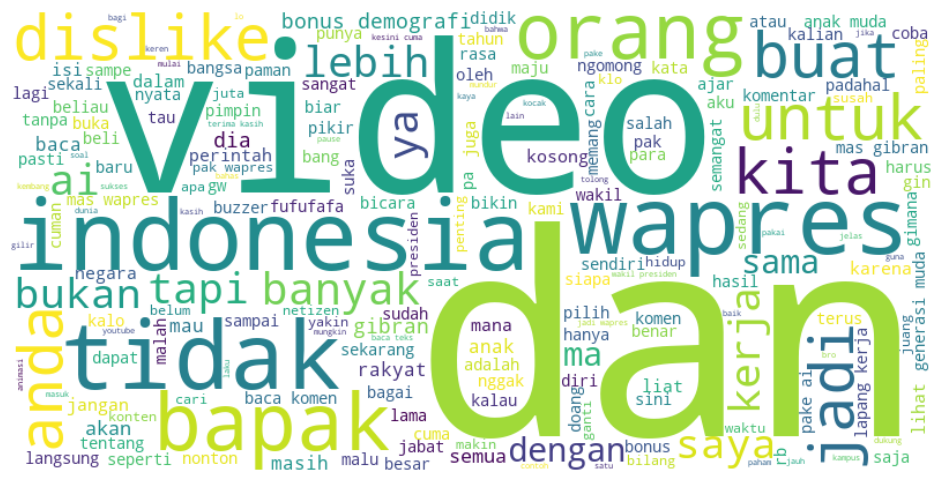

In [112]:
# 1. Inisialisasi Stemmer Sastrawi
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# 2. Daftar stopwords tambahan (bahasa gaul, singkatan, dll)
stopwords_tambahan = set([
    'yg', 'yang', 'di', 'ke', 'dari', 'ga', 'gak', 'gk', 'aja', 'dong', 'deh',
    'nih', 'sih', 'lah', 'nya', 'gua', 'gue', 'loe', 'lu', 'eh', 'nya', 'si',
    'kok', 'kan', 'pun', 'pada', 'dg', 'tp', 'jd', 'krn', 'udah', 'dah', 'blm',
    'bgt', 'banget', 'abis', 'kayak', 'kayaknya', 'bisa', 'ini', 'itu', 'apa',
    'ada', 'itu'
])

# 3. Fungsi pembersih untuk wordcloud + stemming
def clean_with_sastrawi(text):
    if pd.isna(text):
        return ''
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z\s]", " ", text)  # hanya huruf
    text = ' '.join(text.split())  # hapus spasi berlebih
    text = ' '.join([word for word in text.split() if word not in stopwords_tambahan])  # hapus stopwords
    return stemmer.stem(text)

# 4. Terapkan pembersihan pada kolom komentar asli
data['cleaned_stemmed_text'] = data['Text'].apply(clean_with_sastrawi)

# 5. Gabungkan semua komentar
all_words = ' '.join(data['cleaned_stemmed_text'])

# 6. WordCloud dari teks yang sudah distem dan dibersihkan
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


# Membersihkan komentar dari simbol khusus 
hal ini di lakukan karena simbol khusus bisa saja mempengaruhi hasil akhir dari labeling sentiment, di sini saya menggunakan library `re`

In [102]:
# 1. Fungsi untuk membersihkan komentar
def clean_komen(text):
    if pd.isna(text):
        return ''
    cleaned = re.sub(r"(@[A-Za-z0-9_]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", str(text))
    return ' '.join(cleaned.split())

# 2. Fungsi translate aman
def safe_translate(text, target='en', retries=5, delay=5):
    if pd.isna(text) or text.strip() == '':
        return ''
    text_str = str(text)
    for i in range(retries):
        try:
            return GoogleTranslator(source='auto', target=target).translate(text_str)
        except Exception as e:
            print(f"Attempt {i+1} failed for: '{text_str[:50]}...'\n{e}")
            if i < retries - 1:
                time.sleep(delay)
            else:
                return ''

# Menerjemahkan komentar ke bahasa inggris
# lalu di lanjut memberikan labeling sentimen  menggunakan library`transformers`

Mulai menerjemahkan komentar...


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


Mulai analisis sentimen...


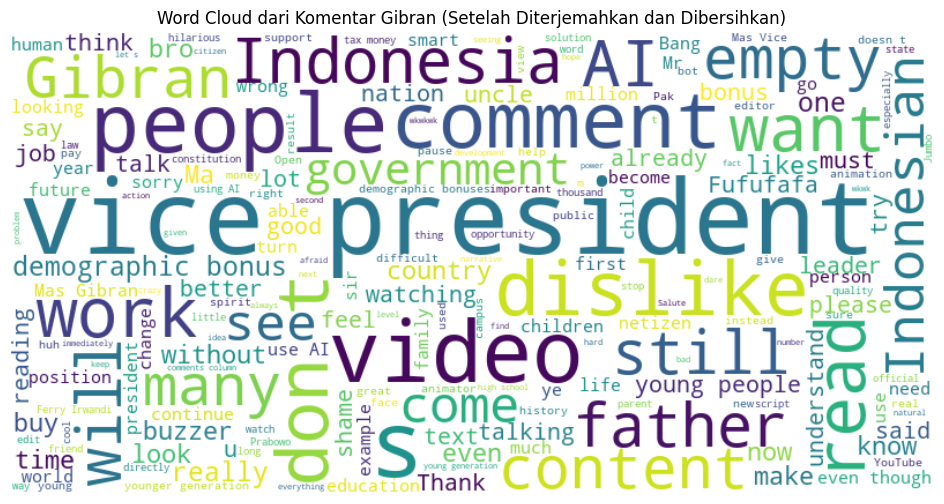

                                                Text  \
0  anda jangan pernah sekali kali berpikir bahwa ...   
1  salut sama editornya kuat ngedit video ini sam...   
2                         bisa gak wapres diganti ai   
3  80rb like dalam 48 jam terakhir? kami gak rela...   
4                                  kosongnya natural   

                                     translated_text  \
0  You should never think that your video is cool...   
1  Salute to the editor to edit this video while ...   
2           Can the Vice President be replaced by AI   
3  80 thousand like in the last 48 hours? We are ...   
4                                      Natural empty   

                             cleaned_translated_text sentiment  
0  You should never think that your video is cool...  POSITIVE  
1  Salute to the editor to edit this video while ...  NEGATIVE  
2           Can the Vice President be replaced by AI  NEGATIVE  
3  80 thousand like in the last 48 hours We are n...  NEGATIVE  
4

In [103]:
# 1. Terjemahkan komentar
print("Mulai menerjemahkan komentar...")
data['translated_text'] = data['Text'].apply(lambda x: safe_translate(x, target='en'))

# 2. Bersihkan hasil terjemahan
data['cleaned_translated_text'] = data['translated_text'].apply(clean_komen)

# 3. Analisis sentimen
classifier = pipeline("sentiment-analysis")

def classify_sentiment(text):
    if not text or text.strip() == '':
        return 'UNKNOWN'
    try:
        result = classifier(text)[0]
        label = result['label']
        score = result['score']
        return 'NEUTRAL' if score < 0.6 else label
    except Exception as e:
        print(f"Error saat analisis sentimen: {e}")
        return 'UNKNOWN'

print("Mulai analisis sentimen...")
data['sentiment'] = data['cleaned_translated_text'].apply(classify_sentiment)

# 4. Tokenisasi
data['tokens'] = data['cleaned_translated_text'].apply(lambda x: x.lower().split() if x else [])

# 5. WordCloud dari teks terjemahan yang sudah dibersihkan
all_words = ' '.join(data['cleaned_translated_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud dari Komentar Gibran (Setelah Diterjemahkan dan Dibersihkan)')
plt.show()

# 6. Tampilkan hasil akhir
print(data[['Text', 'translated_text', 'cleaned_translated_text', 'sentiment']].head())

In [104]:
# 1. Inisialisasi pipeline analisis sentimen dari HuggingFace
classifier = pipeline("sentiment-analysis")

# 2. Fungsi klasifikasi sentimen dengan 3 label: POSITIVE, NEGATIVE, NEUTRAL
def classify_sentiment_3label(text):
    if not text or text.strip() == '':
        return 'UNKNOWN'
    try:
        result = classifier(text)[0]
        label = result['label']  # 'POSITIVE' atau 'NEGATIVE'
        score = result['score']  # confidence score
        
        if score < 0.6:
            return 'NEUTRAL'
        elif label.upper() == 'POSITIVE':
            return 'POSITIVE'
        elif label.upper() == 'NEGATIVE':
            return 'NEGATIVE'
        else:
            return 'NEUTRAL'
    except Exception as e:
        print(f"Error saat klasifikasi: {e}")
        return 'UNKNOWN'

# 3. Terapkan klasifikasi sentimen ke kolom hasil terjemahan yang sudah dibersihkan
print("Melabeli komentar dengan sentimen POSITIVE, NEGATIVE, NEUTRAL...")
data['sentiment'] = data['cleaned_translated_text'].apply(classify_sentiment_3label)

# 4. Tampilkan 5 data pertama
print(data[['cleaned_translated_text', 'sentiment']].head())

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


Melabeli komentar dengan sentimen POSITIVE, NEGATIVE, NEUTRAL...
                             cleaned_translated_text sentiment
0  You should never think that your video is cool...  POSITIVE
1  Salute to the editor to edit this video while ...  NEGATIVE
2           Can the Vice President be replaced by AI  NEGATIVE
3  80 thousand like in the last 48 hours We are n...  NEGATIVE
4                                      Natural empty  NEGATIVE


C:\Users\rizqy\AppData\Local\Temp\ipykernel_22660\769321148.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=data, palette='Set2', order=order)


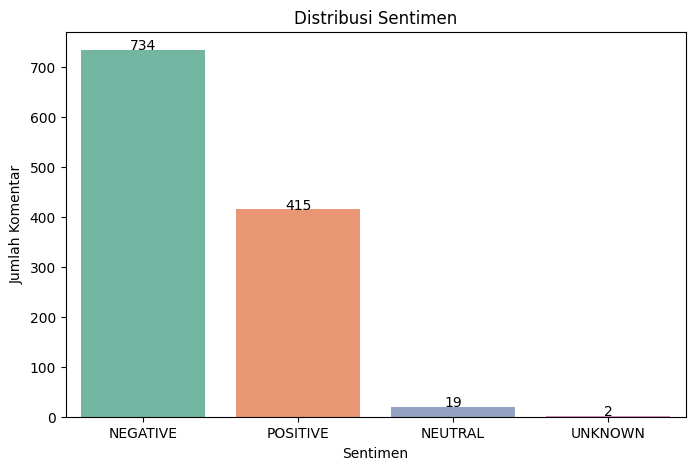

In [105]:
plt.figure(figsize=(8,5))

# Dapatkan urutan label yang dipakai countplot
order = data['sentiment'].value_counts().index

# Plot countplot dengan urutan label yang konsisten
sns.countplot(x='sentiment', data=data, palette='Set2', order=order)

plt.title('Distribusi Sentimen')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Komentar')

# Tampilkan jumlah di atas bar menggunakan patches
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 1, f'{int(height)}', ha='center')

plt.show()

Akurasi: 0.6239316239316239

Classification Report:
               precision    recall  f1-score   support

    NEGATIVE       0.62      0.99      0.76       144
     NEUTRAL       0.00      0.00      0.00         3
    POSITIVE       0.75      0.03      0.07        87

    accuracy                           0.62       234
   macro avg       0.46      0.34      0.28       234
weighted avg       0.66      0.62      0.50       234



C:\Users\rizqy\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rizqy\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rizqy\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

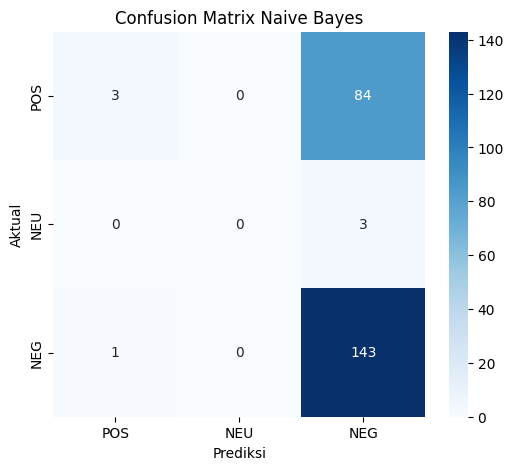

In [106]:
# 1. Drop data yang UNKNOWN (tidak bisa diklasifikasi)
df = data[data['sentiment'] != 'UNKNOWN'].copy()

# 2. Fitur: teks komentar, Label: sentimen
X = df['cleaned_translated_text']
y = df['sentiment']

# 3. TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=3000)  
X_tfidf = tfidf.fit_transform(X)

# 4. Split data train/test
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# 5. Naive Bayes Classifier
model = MultinomialNB()
model.fit(X_train, y_train)

# 6. Prediksi
y_pred = model.predict(X_test)

# 7. Evaluasi
print("Akurasi:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 8. Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred, labels=['POSITIVE', 'NEUTRAL', 'NEGATIVE'])

plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['POS', 'NEU', 'NEG'], yticklabels=['POS', 'NEU', 'NEG'])
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix Naive Bayes')
plt.show()


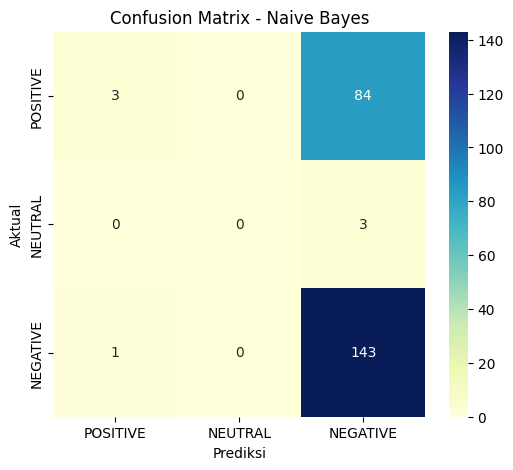

In [107]:
# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred, labels=['POSITIVE', 'NEUTRAL', 'NEGATIVE'])

# Visualisasi
plt.figure(figsize=(6,5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=['POSITIVE', 'NEUTRAL', 'NEGATIVE'],
            yticklabels=['POSITIVE', 'NEUTRAL', 'NEGATIVE'])
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()


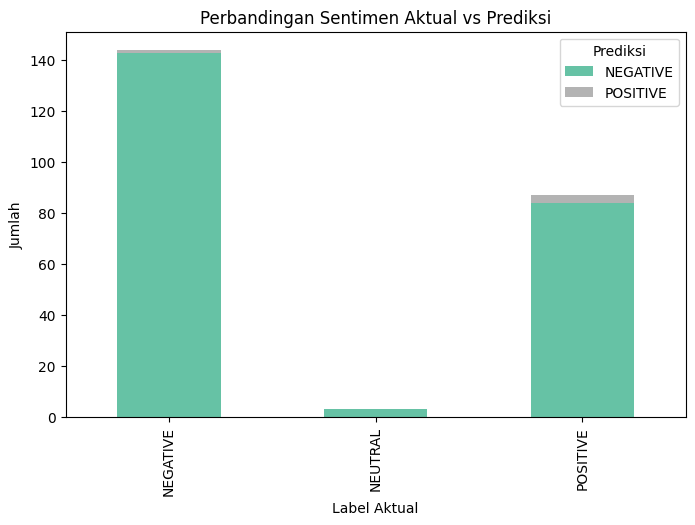

In [108]:
# Buat DataFrame perbandingan
compare_df = pd.DataFrame({'Aktual': y_test, 'Prediksi': y_pred})

# Hitung jumlah per kombinasi (Aktual vs Prediksi)
cross_tab = pd.crosstab(compare_df['Aktual'], compare_df['Prediksi'])

# Plot sebagai bar stack
cross_tab.plot(kind='bar', stacked=True, colormap='Set2', figsize=(8,5))
plt.title('Perbandingan Sentimen Aktual vs Prediksi')
plt.xlabel('Label Aktual')
plt.ylabel('Jumlah')
plt.legend(title='Prediksi')
plt.show()


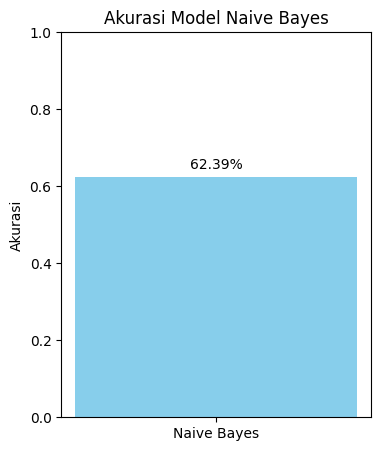

In [109]:
akurasi = accuracy_score(y_test, y_pred)

# Bar chart akurasi
plt.figure(figsize=(4,5))
plt.bar(['Naive Bayes'], [akurasi], color='skyblue')
plt.ylim(0, 1)
plt.title('Akurasi Model Naive Bayes')
plt.ylabel('Akurasi')
plt.text(0, akurasi + 0.02, f"{akurasi:.2%}", ha='center')
plt.show()


C:\Users\rizqy\AppData\Local\Temp\ipykernel_22660\3964872478.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='sentiment', y='count', data=sentiment_df, palette='Set2')


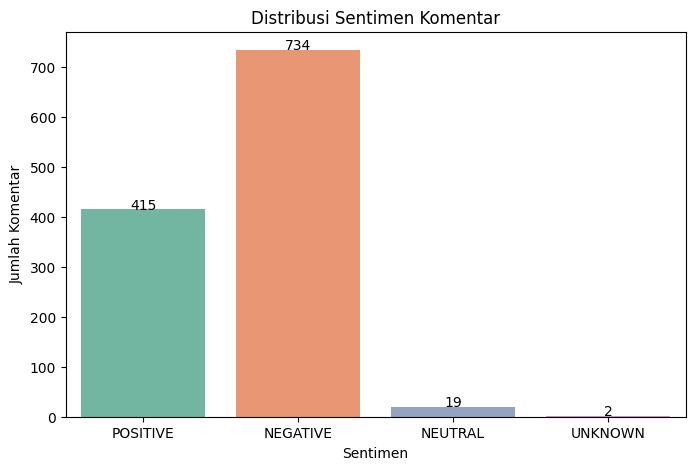

In [110]:
# Hitung jumlah setiap kategori sentimen (include UNKNOWN)
sentiment_counts = data['sentiment'].value_counts()

# Pastikan urutan yang ingin ditampilkan
order = ['POSITIVE', 'NEGATIVE', 'NEUTRAL', 'UNKNOWN']

# Buat dataframe khusus dengan urutan label yang konsisten
import pandas as pd
sentiment_df = pd.DataFrame({
    'sentiment': order,
    'count': [sentiment_counts.get(label, 0) for label in order]
})

# Plot barchart
plt.figure(figsize=(8,5))
sns.barplot(x='sentiment', y='count', data=sentiment_df, palette='Set2')

# Tambahkan jumlah di atas bar
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, height + 1, f'{int(height)}', ha='center')

plt.title('Distribusi Sentimen Komentar')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Komentar')
plt.show()


In [111]:
# Buat dataframe test asli dan prediksi
df_compare = pd.DataFrame({'actual': y_test, 'predicted': y_pred})

# Distribusi label asli di test set
print("Distribusi label asli:")
print(df_compare['actual'].value_counts())

# Distribusi prediksi model di test set
print("\nDistribusi prediksi model:")
print(df_compare['predicted'].value_counts())

Distribusi label asli:
actual
NEGATIVE    144
POSITIVE     87
NEUTRAL       3
Name: count, dtype: int64

Distribusi prediksi model:
predicted
NEGATIVE    230
POSITIVE      4
Name: count, dtype: int64
